In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
import itertools
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
%matplotlib inline
params = {'xtick.labelsize':'x-large', 'ytick.labelsize':'x-large',
         'figure.figsize': (12,5), "axes.labelsize":'x-large'}
plt.rcParams.update(params)

In [14]:
data = pd.read_pickle('res_age.p')
print(len(data))

1261


In [15]:
data['sample_size'] = data.g1t + data.g2t
data = data.rename(columns={'imbal':'imbalance'})
data.head()

,effect,g1_mean,g2_mean,g1_sd_sample,g2_sd_sample,imbalance,ngrps,g1t,g2t,g1counts,g2counts,grouplabels,sample_size
NCT00000371,0.031798,27.0,28.0,1.610807,1.534536,0.000000,3,27,28,"[0.0, 0.0, 27.0]","[0.0, 0.0, 28.0]","[<=18 years, >=65 years, Between 18 and 65 years]",55
NCT00001596,0.105295,3.0,11.0,25.590000,24.320000,0.043478,3,23,12,"[0.0, 1.0, 22.0]","[0.0, 0.0, 12.0]","[<=18 years, >=65 years, Between 18 and 65 years]",35
NCT00001723,0.300000,100.0,100.0,0.200000,0.200000,0.000000,3,100,100,"[100.0, 0.0, 0.0]","[100.0, 0.0, 0.0]","[<=18 years, >=65 years, Between 18 and 65 years]",200
NCT00004500,0.224826,31.0,38.0,8.520000,9.960000,0.000000,3,38,31,"[38.0, 0.0, 0.0]","[31.0, 0.0, 0.0]","[<=18 years, >=65 years, Between 18 and 65 years]",69
NCT00035815,0.102158,163.0,167.0,0.390000,0.570000,0.016972,3,167,163,"[0.0, 32.0, 135.0]","[0.0, 34.0, 129.0]","[<=18 years, >=65 years, Between 18 and 65 years]",330


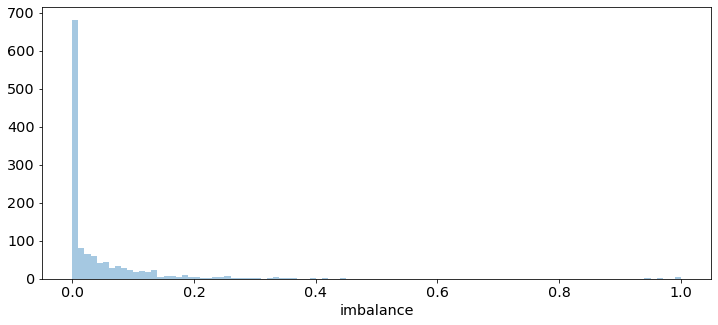

In [16]:
sns.distplot(data['imbalance'], kde=False, bins=100)

In [17]:
data.imbalance.describe(np.arange(0, 1, 0.05))

count    1261.000000
mean        0.043858
std         0.096152
min         0.000000
0%          0.000000
5%          0.000000
10%         0.000000
15%         0.000000
20%         0.000000
25%         0.000000
30%         0.000000
35%         0.000000
40%         0.000000
45%         0.000000
50%         0.002814
55%         0.011107
60%         0.018382
65%         0.028986
70%         0.039216
75%         0.054421
80%         0.071429
85%         0.095588
90%         0.126374
95%         0.189189
max         1.000000
Name: imbalance, dtype: float64

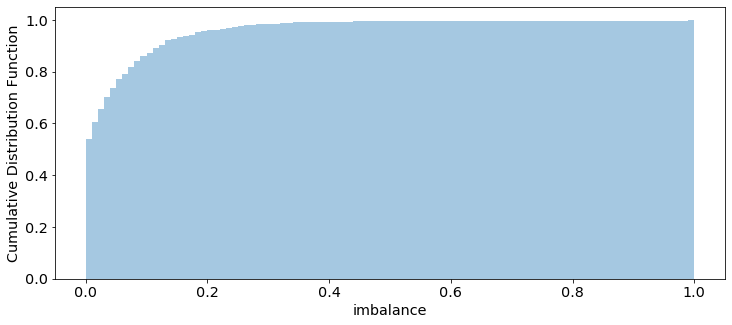

In [18]:
sns.distplot(
    data['imbalance'], kde=False, hist_kws={'cumulative': True}, norm_hist=True,
    bins=100
)
plt.ylabel('Cumulative Distribution Function')
plt.show()

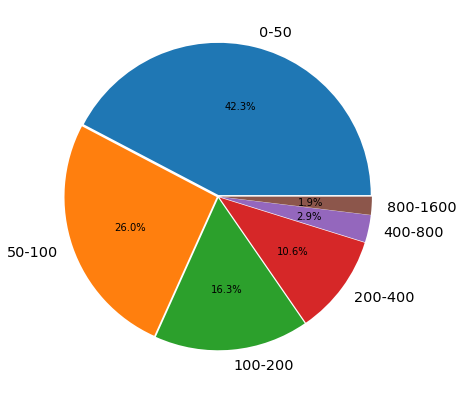

In [19]:
# trial size distribution
labels = []
shares = []

sample_sizes = [0, 50, 100, 200, 400, 800, 1600]
for i in range(len(sample_sizes)-1):
    lower, upper = sample_sizes[i:i+2]
    shares.append(
        data.sample_size.between(lower, upper).mean().round(2))
    labels.append('{}-{}'.format(lower, upper))    
    
plt.figure(figsize=(7, 7))
plt.pie(shares, explode=[.01] * len(shares), labels=labels, autopct='%.1f%%')
plt.show()

In [20]:
data.sample_size.describe()

count    1261.000000
mean      135.379064
std       339.788504
min        16.000000
25%        32.000000
50%        60.000000
75%       125.000000
max      6543.000000
Name: sample_size, dtype: float64

In [22]:
# ensure treatment and control groups are of similar sizes?
data = data.loc[np.log(data.g1t/data.g2t).abs() <= np.log(3)]
print(data.shape)

(1248, 13)


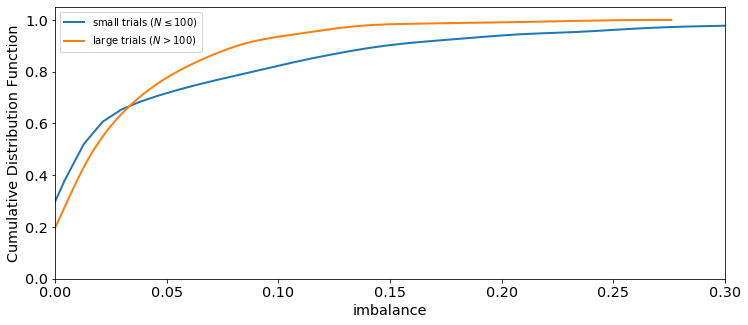

In [23]:
sns.distplot(
    data['imbalance'].loc[data.sample_size.between(0,100)], hist=False,
    kde_kws={'cumulative': True, "lw": 2, "label": "small trials $(N \leq 100)$"}, 
    norm_hist=True, 
    bins=100
)
sns.distplot(
    data['imbalance'].loc[data.sample_size > 100], hist=False,
    kde_kws={'cumulative': True, "lw": 2, "label": 'large trials $(N > 100)$'}, 
    norm_hist=True,
    bins=100
)
plt.xlim(0, .3)
plt.ylabel('Cumulative Distribution Function')
plt.show()

### Relative Imbalance was skipped, potentially it can be implementable if we look through the multi buckets

In [24]:
# additional variables

def average_sd(x):
    g1t, g2t, g1_sd_sample, g2_sd_sample = x
    return np.sqrt(g1t * g1_sd_sample **2 + g2t * g2_sd_sample ** 2) / np.sqrt(g1t + g2t)
    
data['average_sd'] = data[['g1t', 'g2t', 'g1_sd_sample', 'g2_sd_sample']].apply(
    average_sd, axis=1
)
data.head().T

,NCT00000371,NCT00001596,NCT00001723,NCT00004500,NCT00035815
effect,0.0317977,0.105295,0.3,0.224826,0.102158
g1_mean,27,3,100,31,163
g2_mean,28,11,100,38,167
g1_sd_sample,1.61081,25.59,0.2,8.52,0.39
g2_sd_sample,1.53454,24.32,0.2,9.96,0.57
imbalance,0,0.0434783,0,0,0.0169722
ngrps,3,3,3,3,3
g1t,27,23,100,38,167
g2t,28,12,100,31,163
g1counts,"[0.0, 0.0, 27.0]","[0.0, 1.0, 22.0]","[100.0, 0.0, 0.0]","[38.0, 0.0, 0.0]","[0.0, 32.0, 135.0]"


In [25]:
data['signed_effect'] = (data['g1_mean'] - data['g2_mean']) / data['average_sd']
data['effect_size'] = data.signed_effect.abs()
data['bias'] = (1/data.g1t) + (1/data.g2t)
data['inverse_sample_size'] = 1/data.sample_size
data = data.loc[data.signed_effect.abs() < 3]

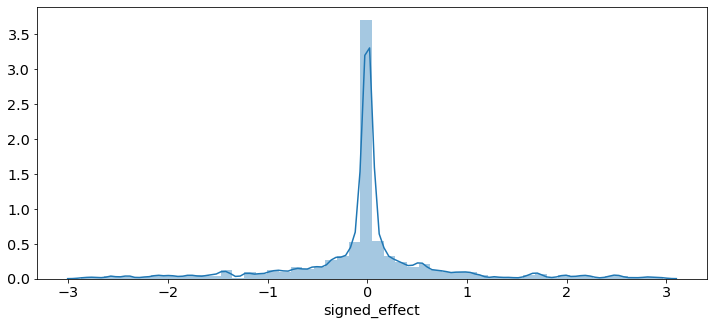

In [26]:
sns.distplot(data.signed_effect)

In [27]:
selected_data = data.copy()
selected_data = selected_data.loc[selected_data.imbalance.between(.02, .25)]

In [28]:
selected_data['residuals'] = np.square(selected_data.signed_effect
                                       - selected_data.signed_effect.mean()) - selected_data.bias
selected_data['square_imbalance'] = np.square(selected_data.imbalance)

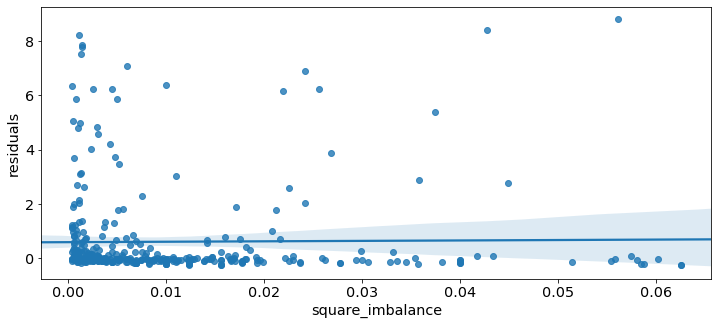

In [29]:
sns.regplot('square_imbalance', 'residuals', selected_data)

In [30]:
import matplotlib.ticker as mtick

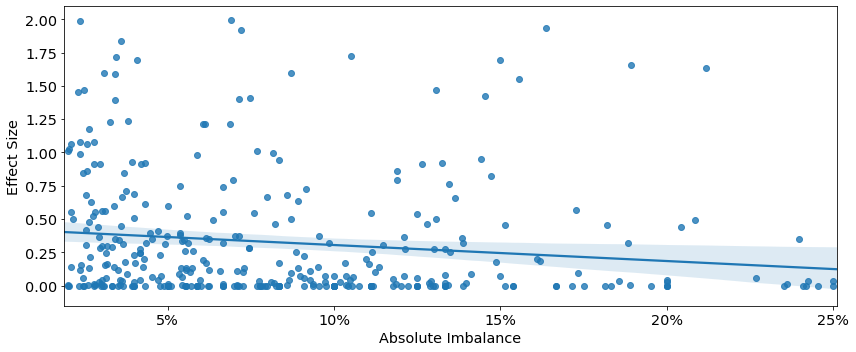

In [31]:
ax = sns.regplot('imbalance', 'effect_size', selected_data.loc[selected_data.effect_size <2])
plt.ylabel('Effect Size')
plt.xlabel('Absolute Imbalance')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
plt.xlim(0.019,.251)
plt.tight_layout()
# plt.savefig('figs/regplot_imbalance_effect_size.pdf')
plt.show()

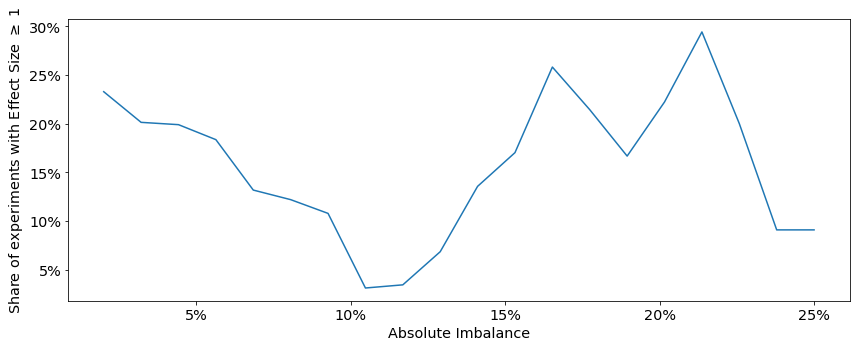

In [32]:
step = .025
share_large_effects = []

for imbalance in np.linspace(.02, .25, 20):
    is_large = (selected_data.loc[selected_data.imbalance.between(imbalance - step, imbalance + step)
                             ].effect_size >= 1)
    share_large_effects.append(is_large.mean())
    std_error = [is_large.std()]
share_large_effects

fig, ax = plt.subplots()
plt.plot(np.linspace(.02, .25, 20), share_large_effects)
plt.xlabel('Absolute Imbalance')
plt.ylabel('Share of experiments with Effect Size $\geq$ 1')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))

plt.tight_layout()
# plt.savefig('figs/regplot_imbalance_large_effect_size.pdf')
plt.show()

In [33]:
mod = smf.ols('effect_size ~ imbalance', selected_data)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            effect_size   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.658
Date:                Wed, 04 Nov 2020   Prob (F-statistic):              0.104
Time:                        21:14:31   Log-Likelihood:                -397.75
No. Observations:                 380   AIC:                             799.5
Df Residuals:                     378   BIC:                             807.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5505      0.066      8.391      0.0

In [34]:
mod = smf.ols('effect_size ~ imbalance + inverse_sample_size' , selected_data)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            effect_size   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     6.717
Date:                Wed, 04 Nov 2020   Prob (F-statistic):            0.00136
Time:                        21:14:31   Log-Likelihood:                -392.43
No. Observations:                 380   AIC:                             790.9
Df Residuals:                     377   BIC:                             802.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.6414    

In [35]:
mod = smf.ols('residuals ~ square_imbalance', selected_data)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              residuals   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                   0.05536
Date:                Wed, 04 Nov 2020   Prob (F-statistic):              0.814
Time:                        21:14:32   Log-Likelihood:                -728.44
No. Observations:                 380   AIC:                             1461.
Df Residuals:                     378   BIC:                             1469.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.5925      0.108  

In [36]:
mod = smf.ols('residuals ~ square_imbalance + inverse_sample_size', selected_data)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              residuals   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     7.407
Date:                Wed, 04 Nov 2020   Prob (F-statistic):           0.000699
Time:                        21:14:32   Log-Likelihood:                -721.14
No. Observations:                 380   AIC:                             1448.
Df Residuals:                     377   BIC:                             1460.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.9485    

In [37]:
mod = smf.quantreg('residuals ~ square_imbalance', selected_data)
res = mod.fit(q=.5)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:              residuals   Pseudo R-squared:             0.003519
Model:                       QuantReg   Bandwidth:                      0.1801
Method:                 Least Squares   Sparsity:                       0.4350
Date:                Wed, 04 Nov 2020   No. Observations:                  380
Time:                        21:14:33   Df Residuals:                      378
                                        Df Model:                            1
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0020      0.014     -0.142      0.887      -0.030       0.026
square_imbalance    -2.1765      0.883     -2.464      0.014      -3.913      -0.440


In [38]:
mod = smf.quantreg('residuals ~ square_imbalance + inverse_sample_size', selected_data)
res = mod.fit(q=.5)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:              residuals   Pseudo R-squared:              0.03060
Model:                       QuantReg   Bandwidth:                      0.1754
Method:                 Least Squares   Sparsity:                       0.3627
Date:                Wed, 04 Nov 2020   No. Observations:                  380
Time:                        21:14:33   Df Residuals:                      377
                                        Df Model:                            2
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0548      0.016      3.482      0.001       0.024       0.086
square_imbalance       -0.4998      0.779     -0.642      0.522      -2.032       1.032
inverse_sample_size    -4.8224      0.658     -7.331      0.000      -6.116      -3.529
